C:\Users\kyle\AppData\Local\Temp\ipykernel_20276\2493821063.py:32: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  days = (date - pd.datetime(2000, 12, 21)).days


(8.0, 17.0)

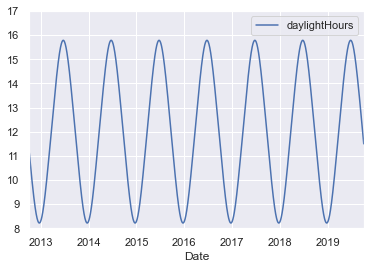

In [43]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV
from pandas.tseries.holiday import USFederalHolidayCalendar



# These files may take a while to open because they are very large.
counts = pd.read_csv('FremontBridge.csv', index_col='Date', parse_dates=True)
weather = pd.read_csv('BicycleWeather.csv', index_col='DATE', parse_dates=True)

daily = counts.resample('d').sum()
daily['Total'] = daily.sum(axis = 1)
daily = daily[['Total']]
days = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']

for i in range(7):
    daily[days[i]] = (daily.index.dayofweek == i).astype(float)
    
calendar = USFederalHolidayCalendar()
holidays = calendar.holidays('2012','2016')
daily = daily.join(pd.Series(1, index=holidays, name='holiday'))
daily['holiday'].fillna(0, inplace=True)

def hoursOfDaylight(date, axis = 23.44, latitude = 47.61):
    days = (date - pd.datetime(2000, 12, 21)).days
    m = (1. - np.tan(np.radians(latitude)) * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m,0,2))) / 180.

daily['daylightHours'] = list(map(hoursOfDaylight, daily.index))
daily[['daylightHours']].plot()
plt.ylim(8,17)


In [47]:
#Convert Temp to Celsius
weather['TMIN'] /= 10
weather['TMAX'] /= 10
weather['Temp (C)'] = 0.5 * (weather['TMIN'] + weather['TMAX'])

#Convert precipitation to inches
weather['PRCP'] /= 254
weather['dry day'] = (weather['PRCP'] == 0).astype(int)

#daily = daily.join(weather[['PRCP', 'Temp (C)', 'dry day']])
# how='left' means calling frame’s index 
daily = daily.join(weather[['PRCP', 'Temp (C)', 'dry day']], how='left', lsuffix='_left', rsuffix='_right')

daily[:5]

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylightHours,PRCP_left,Temp (C)_left,dry day_left,PRCP_right,Temp (C)_right,dry day_right,annual,PRCP,Temp (C),dry day
Date,,,,,,,,,,,,,,,,,,,,
2012-10-03,3521.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.0,13.35,1.0,0.0,1.335,1.0,0.000000,0.0,0.1335,1
2012-10-04,3475.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.0,13.60,1.0,0.0,1.360,1.0,0.002740,0.0,0.1360,1
2012-10-05,3148.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.0,15.30,1.0,0.0,1.530,1.0,0.005479,0.0,0.1530,1
2012-10-06,2006.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.0,15.85,1.0,0.0,1.585,1.0,0.008219,0.0,0.1585,1
2012-10-07,2142.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208,0.0,15.85,1.0,0.0,1.585,1.0,0.010959,0.0,0.1585,1


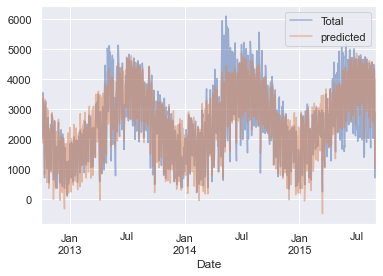

In [48]:
daily['annual'] = (daily.index - daily.index[0]).days / 365.

#Linear Regression
daily.dropna(axis=0, how='any', inplace=True)

column_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday',
                'daylightHours', 'PRCP', 'dry day', 'Temp (C)', 'annual']
X = daily[column_names]
y = daily['Total']

model = LinearRegression(fit_intercept=False)
model.fit(X, y)
daily['predicted'] = model.predict(X)
daily[['Total','predicted']].plot(alpha=0.5);

In [49]:
parameters = pd.Series(model.coef_,index=X.columns)
parameters

Mon              5.048828e+02
Tue              6.102339e+02
Wed              5.926736e+02
Thu              4.823581e+02
Fri              1.779803e+02
Sat             -1.103302e+03
Sun             -1.133567e+03
holiday         -1.187401e+03
daylightHours    1.288515e+02
PRCP            -4.289249e+07
dry day          5.476986e+02
Temp (C)         6.516279e+03
annual           2.694271e+01
dtype: float64

In [50]:
daily[:5]
daily.corr(method='spearman')

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylightHours,...,Temp (C)_left,dry day_left,PRCP_right,Temp (C)_right,dry day_right,annual,PRCP,Temp (C),dry day,predicted
Total,1.000000,0.147496,0.200247,0.186168,0.142324,0.054430,-0.360151,-0.370513,-0.111138,0.619645,...,0.620759,0.429007,-0.465832,0.620954,0.429007,0.235085,-0.465832,0.620572,0.429007,0.932395
Mon,0.147496,1.000000,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,0.195584,0.000398,...,0.019147,0.017129,-0.025984,0.019339,0.017129,0.002658,-0.025984,0.019352,0.017129,0.143697
Tue,0.200247,-0.166667,1.000000,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,-0.018851,0.000651,...,0.004420,-0.010122,0.006232,0.004455,-0.010122,0.003987,0.006232,0.004495,-0.010122,0.212646
Wed,0.186168,-0.166667,-0.166667,1.000000,-0.166667,-0.166667,-0.166667,-0.166667,-0.035347,-0.000582,...,-0.011469,0.000779,0.005944,-0.011731,0.000779,-0.003987,0.005944,-0.011740,0.000779,0.197020
Thu,0.142324,-0.166667,-0.166667,-0.166667,1.000000,-0.166667,-0.166667,-0.166667,0.030634,-0.000407,...,-0.001675,-0.015572,0.010861,-0.001635,-0.015572,-0.002658,0.010861,-0.001622,-0.015572,0.140759
Fri,0.054430,-0.166667,-0.166667,-0.166667,-0.166667,1.000000,-0.166667,-0.166667,-0.035347,-0.000240,...,0.000109,-0.037373,0.026654,0.000289,-0.037373,-0.001329,0.026654,0.000162,-0.037373,0.033788
Sat,-0.360151,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,1.000000,-0.166667,-0.068337,-0.000044,...,-0.005938,0.028030,-0.017684,-0.005990,0.028030,0.000000,-0.017684,-0.006008,0.028030,-0.356990
Sun,-0.370513,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,-0.166667,1.000000,-0.068337,0.000223,...,-0.004595,0.017129,-0.006022,-0.004727,0.017129,0.001329,-0.006022,-0.004639,0.017129,-0.370920
holiday,-0.111138,0.195584,-0.018851,-0.035347,0.030634,-0.035347,-0.068337,-0.068337,1.000000,-0.078683,...,-0.068670,0.059115,-0.050033,-0.068660,0.059115,-0.027033,-0.050033,-0.068961,0.059115,-0.130353
daylightHours,0.619645,0.000398,0.000651,-0.000582,-0.000407,-0.000240,-0.000044,0.000223,-0.078683,1.000000,...,0.790928,0.307485,-0.309827,0.791099,0.307485,0.251385,-0.309827,0.791043,0.307485,0.686756


Lasso Regression highest accuracy is: 0.799358386133696


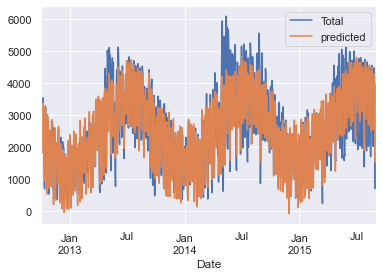

In [52]:
# Lasso Regression

from sklearn.linear_model import Lasso

lassoModel = Lasso()
paramGrid = {'alpha': np.arange(0,10,0.1)}
lassoGrid = RandomizedSearchCV(estimator=lassoModel, param_distributions=paramGrid, n_iter=10)
lassoGrid.fit(X,y)

daily['predicted'] = lassoGrid.predict(X)
daily[['Total', 'predicted']].plot();

#fit data to model and plot on graph
print('Lasso Regression highest accuracy is: ' + str(lassoGrid.best_score_))


Ridge Regression highest accuracy is: 0.814982249237396


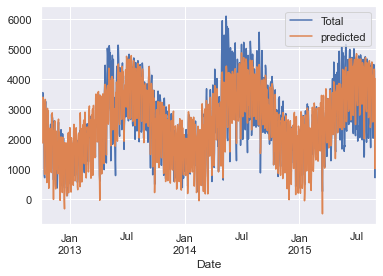

In [53]:
# Ridge Regression
from sklearn.linear_model import Ridge

ridgeModel = Ridge()
paramGrid = {'alpha': np.arange(0,10,0.1)}
ridgeGrid = RandomizedSearchCV(estimator=ridgeModel,param_distributions=paramGrid,n_iter=10)
ridgeGrid.fit(X,y)
daily['predicted'] = ridgeGrid.predict(X)
daily[['Total','predicted']].plot();

print('Ridge Regression highest accuracy is: ' + str(ridgeGrid.best_score_))

Linear Regression highest accuracy is: {'fit_time': array([0.00200009, 0.00200081, 0.00199938, 0.00199962, 0.00200009,
       0.00199866, 0.00200081, 0.00100017, 0.00200057, 0.00200033]), 'score_time': array([0.00200057, 0.00100064, 0.00200081, 0.00200057, 0.0010004 ,
       0.00099993, 0.00099993, 0.0010004 , 0.00100017, 0.00100017]), 'test_score': array([0.76240845, 0.73973216, 0.77204997, 0.84523881, 0.73254133,
       0.76075258, 0.82233669, 0.7488259 , 0.77356088, 0.72186362])}


<AxesSubplot:xlabel='Date'>

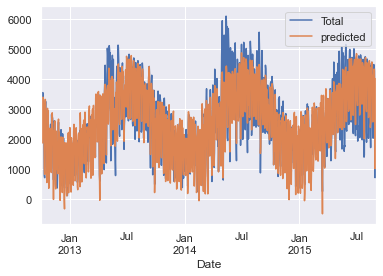

In [55]:
#Linear Regression
from sklearn.model_selection import cross_validate

LrModel = LinearRegression()
LrResults = cross_validate(LrModel,X,y,cv=10)

print('Linear Regression highest accuracy is: ' + str(LrResults))

LrModel.fit(X,y)
daily['predicted'] = LrModel.predict(X)
daily[['Total', 'predicted']].plot(alpha=1)

In [59]:
# Get the best accuracy
bestAcc = max(LrResults)
print('Linear Regression best accuracy is: ' + str(bestAcc))
testBestAcc = max(LrResults['test_score'])
print(testBestAcc)

Linear Regression best accuracy is:test_score
0.8452388066162926


In [63]:
# Figure out which model performs the best
bestModel = []
bestModel.append(str(lassoGrid.best_score_))
bestModel.append(str(ridgeGrid.best_score_))
bestModel.append(testBestAcc)

print('Lasso                  ' + 'Ridge                ' + 'Linear  ')
print(bestModel)


Lasso                  Ridge                Linear  
['0.799358386133696', '0.814982249237396', 0.8452388066162926]
